
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Mem Set Range Gradients (Activations and Params)

In [1]:
#@title Import libraries
import transformer_lens, torch, gc, itertools, functools, math, glob, tqdm
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.bottom'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, gradient, localizing, patching

torch.set_printoptions(precision=2)

## Model

In [2]:
model_type = "gpt-neo-125M"
model = modelHandlers.load_model(model_type=model_type, DEVICE="cpu")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']
setting no_grad on ['embed', 'pos_embed', 'unembed']


## Load Data

In [3]:
range_data = dataLoaders.load_pile_splits(f"acc/{model_type}/ranges", file_names=None)
range_dl = list(map(lambda prompts_counts: torch.utils.data.DataLoader(prompts_counts[0], batch_size=30, shuffle=False), range_data))

from /home/jupyter/paraMem/data/pile_splits/acc/gpt-neo-125M/ranges loading ['0_10.pt', '10_20.pt', '20_30.pt', '30_40.pt', '40_50.pt']...


### Run backprop and gather gradients

In [4]:
def collect_pool_activs(model, cache:dict=None, c_type:str=None, I_range=None):
    vals, names = localizing.collect_c_type(model=model, cache=cache, c_type=c_type)
    pool_vals = localizing.pool_tensor(vals, pool="max", abs_vals=True, topP=0.01, norm_by_entries=False)
    
    ## consider either all tokens or only selected token, then mean over sequences    
    if I_range is not None: 
        pool_vals = pool_vals[:,I_range[0]:I_range[1]]
    pool_vals = pool_vals.mean(1) ## pool over tokens
    pool_vals = pool_vals.mean(0) ## pool over seqs
            
    ## reshape for plotting
    names = list()
    if len(pool_vals.shape) == 2: ## attention
        names = [f"{c_type} H{i}" for i in range(0,pool_vals.shape[1])]
    else: ## mlp
        pool_vals = pool_vals.unsqueeze(-1)
        names = [f"{c_type}"]
    return pool_vals, names


def gather_activation_grads(model, cache:dict, I_range:list=[50,100], c_types:list=["q", "k", "v", "z", "pre", "post"]):  #"q", "k", "v", "z", "pre", "post", "attn_out", "mlp_out"
    vals, names = [], []
    for c_type in c_types:
        c_type_vals, c_type_names = collect_pool_activs(model=model, cache=cache, c_type=c_type, I_range=I_range)
        vals.append(c_type_vals)
        names += c_type_names
    vals = torch.cat(vals, dim=-1)
    return vals, names


def gather_param_grads(model, I_range:list=[50,100], c_types:list=["W_K","W_V","W_Q","W_O","W_in","W_out"]):
    param_vals, param_names = [], []
    for c_type in c_types:
        vals, names = localizing.collect_c_type(model=model, cache=None, c_type=c_type) 
        if c_type in ['W_Q', 'W_K', 'W_V', 'W_O']: ## attention
            vals = vals.view(vals.shape[0], vals.shape[1], -1)
            names = [f"{names[0].split('.')[-1]} H{i}" for i in range(vals.shape[0])]
        else: ## mlps
            vals = vals.view(1, vals.shape[0], -1)
            names = [f"{names[0].split('.')[-1]}"]
        pool_vals = localizing.pool_tensor(vals, pool="max", abs_vals=True, topP=0.1, norm_by_entries=False)
        param_vals.append(pool_vals)
        param_names += names
    param_vals = torch.cat(param_vals, dim=0).T
    return param_vals, param_names

In [5]:
fwd_bwd = "bwd"
grad_type = "params"
I_range=[49,99]

range_vals = []
for i, dl in tqdm.tqdm(enumerate(range_dl[:])):
    toks_NI = next(iter(dl))
    metric = functools.partial(gradient.single_seq_metric, NI_idcs=I_range)
    fwd_cache, bwd_cache, _ = gradient.run_fwd_bwd(model, metric_fn=metric, c_toks_NI=toks_NI)
    if grad_type=="activs":
        vals, names = gather_activation_grads(model, {"fwd":fwd_cache,"bwd":bwd_cache}[fwd_bwd], I_range=I_range)
    elif grad_type=="params":
        vals, names = gather_param_grads(model, I_range=I_range)
    range_vals.append(vals)

0it [00:00, ?it/s]

pooling nll_NI torch.Size([30, 50]), pool: {'c': []}
contrast loss: 4.901011943817139
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])


1it [00:11, 11.72s/it]

returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])
pooling nll_NI torch.Size([30, 50]), pool: {'c': []}
contrast loss: 3.583682060241699
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])


2it [00:22, 11.25s/it]

returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])
pooling nll_NI torch.Size([30, 50]), pool: {'c': []}
contrast loss: 2.554948329925537
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])


3it [00:33, 11.06s/it]

returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])
pooling nll_NI torch.Size([30, 50]), pool: {'c': []}
contrast loss: 1.3540974855422974
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])


4it [00:44, 10.87s/it]

returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])
pooling nll_NI torch.Size([30, 50]), pool: {'c': []}
contrast loss: 0.5787259340286255
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])


5it [00:54, 10.95s/it]

returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])


In [6]:
def gradient_stats(range_vals:list):
    total_grad = []
    total_grad_per_layer = []
    total_grad_var = []
    for i, vals in enumerate(range_vals):
        total_grad.append(vals.sum())
        grad_per_layer = [f"{x:.2f}" for x in vals.sum(-1)]
        total_grad_per_layer.append(grad_per_layer)
        total_grad_var.append(torch.var(vals).item())
    return total_grad, total_grad_per_layer, total_grad_var
    
total_grad, total_grad_per_layer, total_grad_var = gradient_stats(range_vals)

## Plot

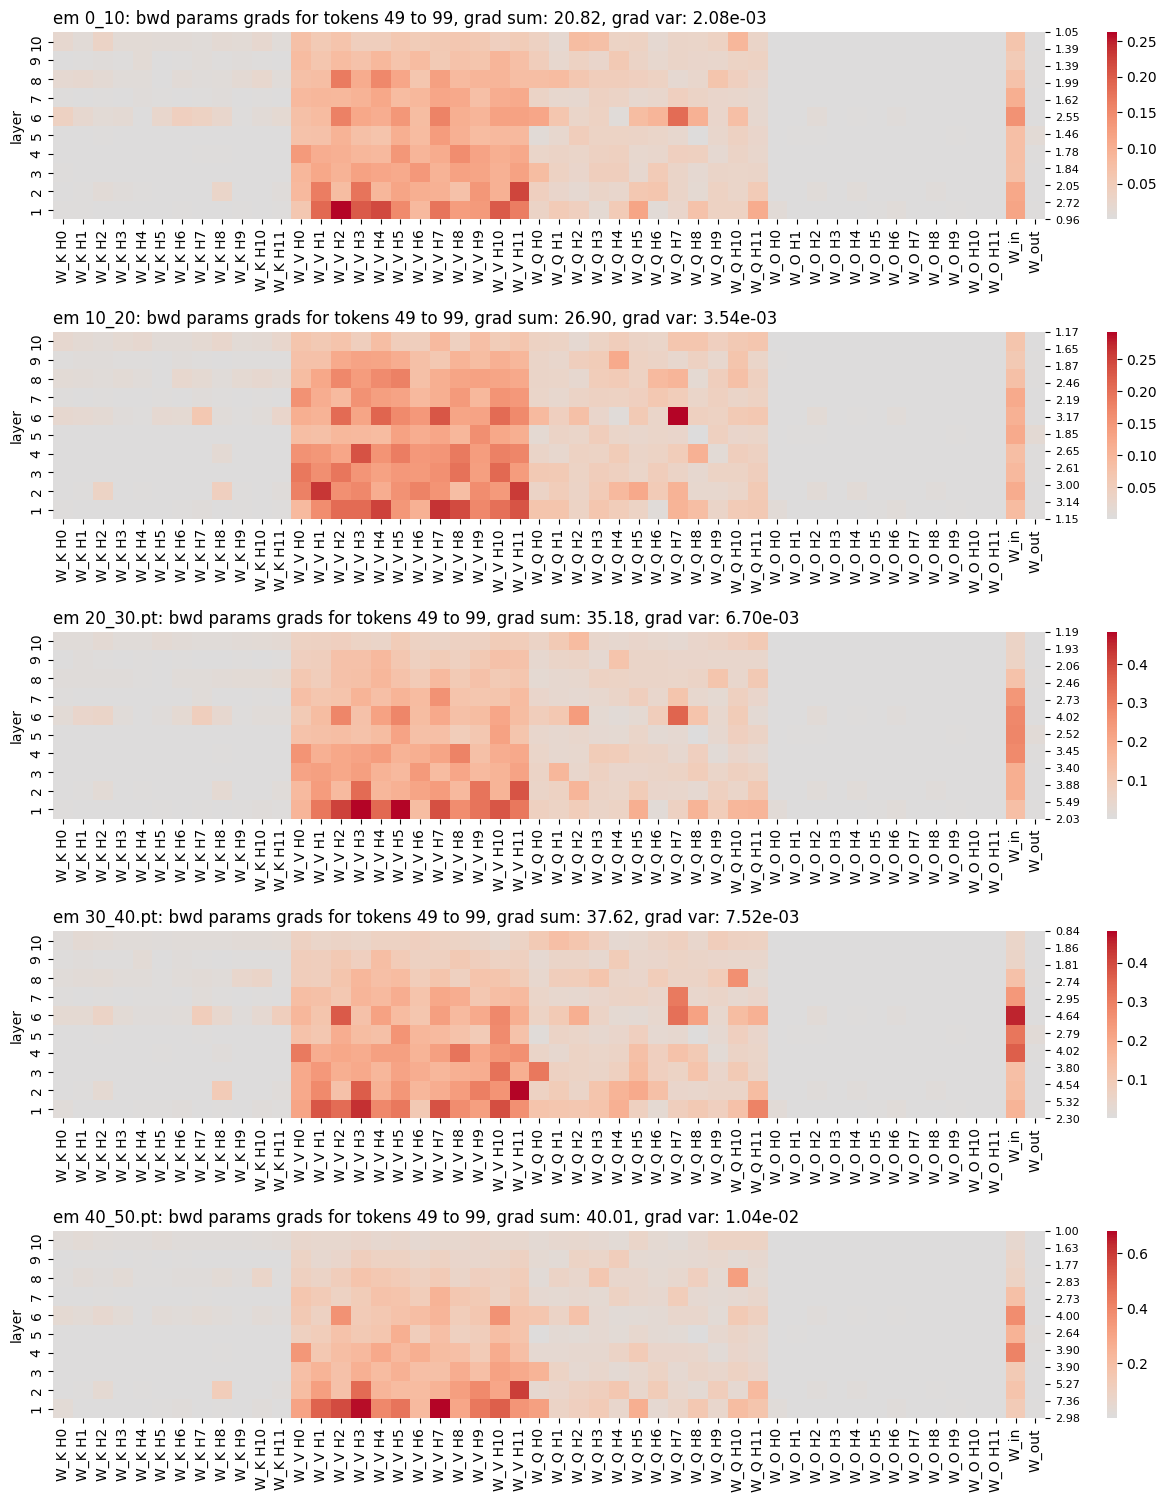

In [7]:
fontsize = 12
fig, axs = plt.subplots(len(range_vals), 1, figsize=(16, 18), gridspec_kw={'hspace': 0.6})

plot_types = ['em 0_10', 'em 10_20', 'em 20_30.pt', 'em 30_40.pt', 'em 40_50.pt']
cmap = "coolwarm"

for i, ax in enumerate(axs):
    plot_vals = range_vals[i].numpy()
    sns.heatmap(plot_vals[1:-1,:],cmap=mpl.colormaps["coolwarm"],center=0.0,xticklabels=names,yticklabels=np.arange(1,plot_vals.shape[0]-1),square=False,ax=ax)# norm=SymLogNorm(linthresh=1.0))
    ax.invert_yaxis()
    ax.set_title(f"{plot_types[i]}: {fwd_bwd} {grad_type} grads for tokens {I_range[0]} to {I_range[1]}, grad sum: {total_grad[i]:.2f}, grad var: {total_grad_var[i]:.2e}", fontsize=fontsize, loc="left")
    ax.set_ylabel("layer")
    
    # Create a second y-axis on the right side
    ax2 = ax.twinx()
    ax2.set_yticks(np.arange(0,len(total_grad_per_layer[i])))
    ax2.set_yticklabels(total_grad_per_layer[i], fontsize = fontsize-4)
    
#fig.savefig(f"{grad_type}_range_{I_range[0]}_{I_range[1]}.png", dpi=200, bbox_inches="tight")